https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### **Imbalanced classification**: developing predictive models on classification datasets that have a severe class imbalance.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesised from the existing examples.
This is a type of data augmentation for the minority class and is referred to as the "Synthetic Minority Oversampling Technique" / "SMOTE".

In [1]:
pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


In [2]:
# check version number
import imblearn
print(imblearn.__version__)

0.13.0


In [3]:
#libraries

from sklearn.datasets import make_classification
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

In [4]:
### use the make_classification() scikit-learn function to create a synthetic binary classification dataset with 10,000 examples and a 1:100 class distribution
# define dataset

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [5]:
# summarise class distribution

#Counter: It is a collection where elements are stored as dictionary keys and their counts are stored as dictionary values.
#Counts are allowed to be any integer value including zero or negative counts.

counter = Counter(y) #in this case with about 9,900 examples in the majority class and 100 in the minority class
print(counter)

Counter({0: 9900, 1: 100})


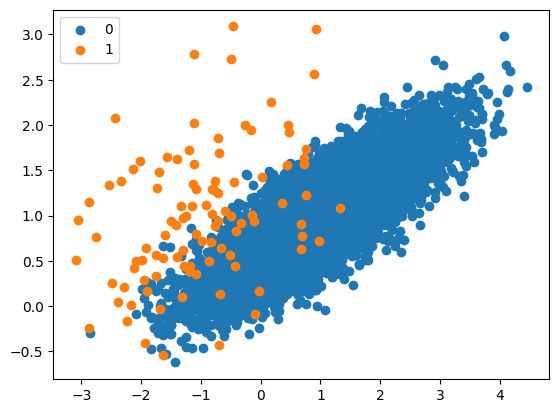

In [6]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

The SMOTE class acts like a data transform object from scikit-learn in that it must be defined and configured, fit on a dataset, then applied to create a new transformed version of the dataset.

In [7]:
#transform the dataset

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [8]:
# summarise the new class distribution

counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9900})


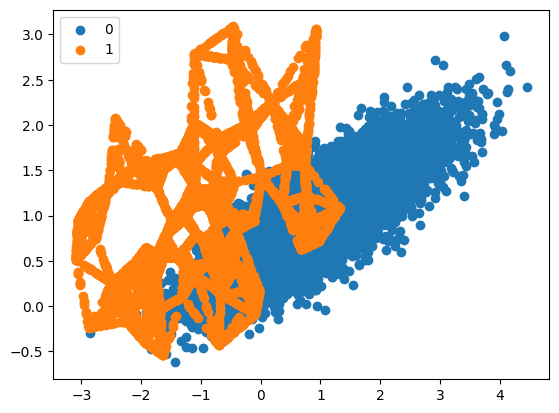

In [9]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

We can update the example to first oversample the minority class to have 10 percent the number of examples of the majority class (e.g. about 1,000), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (e.g. about 2,000).

**Oversample with SMOTE and random undersample for imbalanced dataset**

In [10]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [11]:
# summarise class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


In [12]:
#specify the desired ratios as arguments to the SMOTE and RandomUnderSampler classes

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [13]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [14]:
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [15]:
# summarise the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 1980, 1: 990})


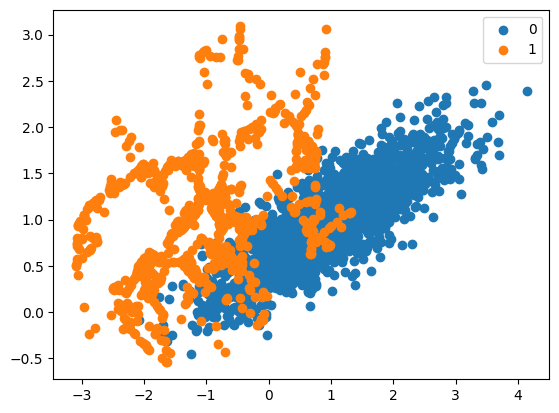

In [16]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

# **SMOTE for Classification**

Use our binary classification dataset from the previous section then fit and evaluate a decision tree algorithm

The algorithm is defined with any required hyperparameters (we will use the defaults), then we will use repeated stratified k-fold cross-validation to evaluate the model. We will use three repeats of 10-fold cross-validation, meaning that 10-fold cross-validation is applied three times fitting and evaluating 30 models on the dataset.

The dataset is stratified, meaning that each fold of the cross-validation split will have the same class distribution as the original dataset, in this case, a 1:100 ratio. We will evaluate the model using the ROC area under curve (AUC) metric. This can be optimistic for severely imbalanced datasets but will still show a relative change with better performing models.

In [17]:
#Libraries

# decision tree evaluated on imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [18]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [19]:
# define model
model = DecisionTreeClassifier()

In [20]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores)) #Evaluates the model and reports the mean ROC AUC

Mean ROC AUC: 0.769


The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, then evaluate the model on the stratified but non-transformed test set.

In [21]:
# define pipeline

steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

This pipeline can then be evaluated using repeated k-fold cross-validation.

In [22]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores)) #evaluates the model and reports the mean ROC AUC score across the multiple folds and repeats

Mean ROC AUC: 0.819


SMOTE may perform better when combined with undersampling of the majority class, such as random undersampling.

Adding a RandomUnderSampler step to the Pipeline.

1) oversample the minority class with SMOTE to about a 1:10 ratio
2) undersample the majority class to achieve about a 1:2 ratio

In [23]:
#Libraries

# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [24]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [25]:
# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [26]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#evaluates the model with the pipeline of SMOTE oversampling and random undersampling on the training dataset
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.843


1) Explore **testing different ratios of the minority class and majority class (e.g. changing the sampling_strategy argument)** to see if a further lift in performance is possible

2) Explore **testing different values of the k-nearest neighbors" selected in the SMOTE procedure when each new synthetic example is created. The **default is k=5, although larger or smaller values will influence the types** of examples created, and in turn, may impact the performance of the model.

In [27]:
#Libraries

# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [28]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [29]:
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
#perform SMOTE oversampling with different k values for the KNN used in the procedure, followed by random undersampling and fitting a decision tree on the resulting training dataset
for k in k_values:
	# define pipeline
	model = DecisionTreeClassifier()
	over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy=0.5)
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.829
> k=2, Mean ROC AUC: 0.832
> k=3, Mean ROC AUC: 0.839
> k=4, Mean ROC AUC: 0.836
> k=5, Mean ROC AUC: 0.828
> k=6, Mean ROC AUC: 0.851
> k=7, Mean ROC AUC: 0.839


# **SMOTE With Selective Synthetic Sample Generation**

Some extensions to SMOTE that are more selective regarding the examples from the minority class that provide the basis for generating new synthetic examples.

# **Borderline-SMOTE**

A popular extension to SMOTE **involves** selecting those instances of the minority class that are misclassified, such as with a k-nearest neighbor classification model.

We can then oversample just those difficult instances, providing more resolution only where it may be required.

In [30]:
#Libraries

# borderline-SMOTE for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE
from matplotlib import pyplot
from numpy import where

In [31]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [32]:
# summarise class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


In [33]:
# transform the dataset
oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(X, y)

In [35]:
# summarise the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9900})


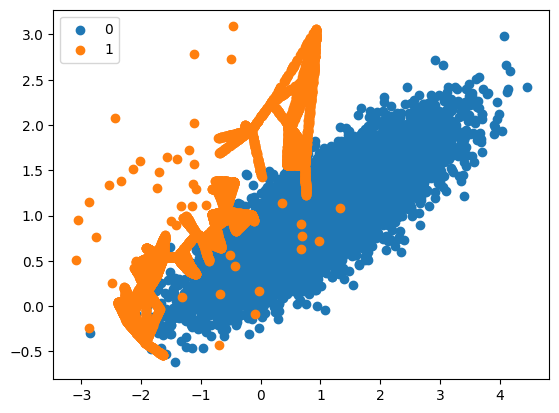

In [36]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

## Borderline-SMOTE **SVM**

An SVM is used to locate the decision boundary defined by the support vectors and examples in the minority class that close to the support vectors become the focus for generating synthetic examples.

In addition to using an SVM, the technique attempts to select regions where there are fewer examples of the minority class and tries to extrapolate towards the class boundary.

In [37]:
#Libraries

# borderline-SMOTE with SVM for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE
from matplotlib import pyplot
from numpy import where

In [38]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [39]:
# summarise class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


In [40]:
# transform the dataset
oversample = SVMSMOTE()
X, y = oversample.fit_resample(X, y)

In [41]:
# summarise the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9900})


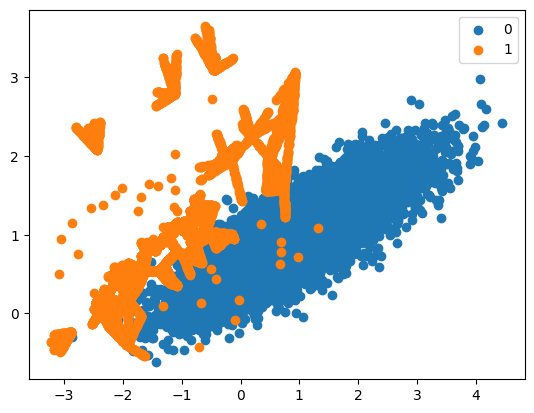

In [42]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

With online Borderline-SMOTE, a discriminative model is not created. Instead, examples in the minority class are weighted according to their density, then those examples with the lowest density are the focus for the SMOTE synthetic example generation process.

# Adaptive Synthetic Sampling (ADASYN)

Approach **involves** generating synthetic samples inversely proportional to the density of the examples in the minority class.

i.e, generate more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.

It is an alternative approach to oversampling on the imbalanced binary classification dataset.

In [43]:
#Libraries

# Oversample and plot imbalanced dataset with ADASYN
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN
from matplotlib import pyplot
from numpy import where

In [48]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [49]:
# summarise class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


In [50]:
# transform the dataset
oversample = ADASYN()
X, y = oversample.fit_resample(X, y)

In [51]:
# summarise the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 9899})


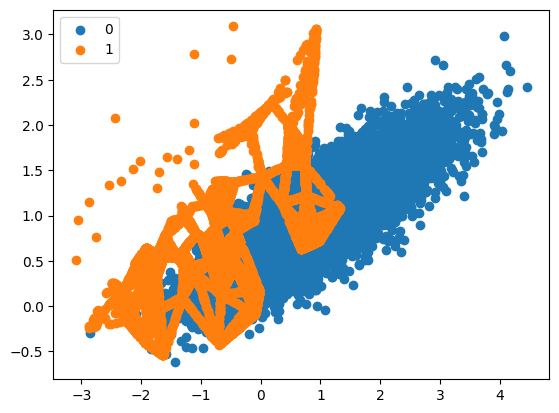

In [52]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()